# Baseline Model

We can use several models for classification:
- Logistic Regression
- K Nearest Neighbors
- SVM
- Random Forest Classifier
- Ensembles
- etc...

As it is a baseline, I will stick to Logistic Regression to see what we get

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression

import utils.mining_data_tb as md

import warnings

warnings.filterwarnings("ignore")

For convenience, some of the processing is packaged in functions

In [2]:
#### Load data
data_path = "data/hospital_train.csv"
variables_path = "data/columns_meaning.csv"

df = md.load_data(data_path, variables_path)

#### Preprocessing of categorical variables, as saw in 0_analysis file
# Preprocessor object
preprocessor = md.preprocessor()

# Process dummies
df = preprocessor.dummies(df)

# Map to process ordinal variables
to_map = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"]

# Process ordinal variables
df = preprocessor.ordinal_mapper(df, to_map)

In [3]:
# Let's take a look at our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                                                     Non-Null Count   Dtype  
---  ------                                                     --------------   -----  
 0   Case_ID registered in Hospital                             100000 non-null  int64  
 1   Unique code for the Hospital                               100000 non-null  int64  
 2   Number of Extra rooms available in the Hospital            100000 non-null  int64  
 3   Condition of Bed in the Ward                               99967 non-null   float64
 4   Unique Patient Id                                          100000 non-null  int64  
 5   City Code for the patient                                  98517 non-null   float64
 6   Admission Type registered by the Hospital                  100000 non-null  int64  
 7   Severity of the illness recorded at the time of admission  100000 non-null  int64  


In [4]:
# Let's fill the NaNs with the mode an we are ready to go
df.iloc[:, 3] = df.iloc[:, 3].fillna(df.iloc[:, 3].mode()[0])
df.iloc[:, 5] = df.iloc[:, 5].fillna(df.iloc[:, 5].mode()[0])

And now we are ready to go

In [5]:
seed = 42

# Independent variables
X = np.array(df.drop("Stay Days by the patient", axis = 1))

# Dependent variable
y = np.array(df["Stay Days by the patient"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = seed)

# Cross validation
# I'll be using stratified k fold because I want to have a similar proportion of all the labels for both training and test sets
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = seed)

# Model
model = LogisticRegression(max_iter = 1000, n_jobs = -1)

In [6]:
# Now let's see how this model performs on the data

# To save scores data
train_scores = []
val_scores = []
count = 1

for (train, val) in kfold.split(X_train, y_train):
    # Train-Validation sets
    x_t, y_t = X_train[train], y_train[train]
    x_v, y_v = X_train[val], y_train[val]

    # Internal structure
    y_t_unique, y_t_counts = np.unique(y_t, return_counts=True)
    y_v_unique, y_v_counts = np.unique(y_v, return_counts=True)

    # Training
    model.fit(x_t, y_t)

    # Scores
    train_score = model.score(x_t, y_t)
    val_score = model.score(x_v, y_v)

    train_scores.append(train_score)
    val_scores.append(val_score)

    # Output
    print(f"Model {count}")
    print("-" * 25)
    print("Set structure:")
    print("Train structure:", dict(zip(y_t_unique, y_t_counts / len(y_t))))
    print("Validation structure:", dict(zip(y_v_unique, y_v_counts / len(y_v))))
    print("-" * 25)
    print("train score:", train_score)
    print("test score:", val_score)
    print("#" * 75)

    count += 1

Model 1
-------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172875, 5: 0.0371875, 6: 0.109875, 7: 0.00875, 8: 0.0330625, 9: 0.0146875, 10: 0.0090625, 11: 0.0220625}
-------------------------
train score: 0.2789375
test score: 0.2788125
###########################################################################
Model 2
-------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172875, 5: 0.0371875, 6: 0.109875, 7: 0.00875, 8: 0.0330625, 9: 0.0146875, 10: 0.0090625, 11: 0.0220625}
-------------------------
train score: 0.279078125


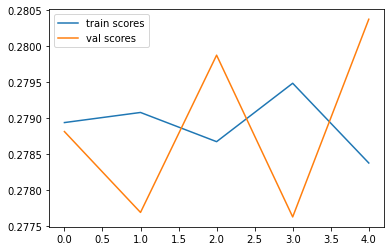

In [7]:
plt.plot(train_scores)
plt.plot(val_scores)
plt.legend(["train scores", "val scores"])
plt.show()

Well, the model performs quite poorly but that was kind of expected given the imbalance in the target_variable. We'll go deeper into that now.

Note: The plot makes the variations of val and train scores look bigger than they actually are. If we check the y-axis, we see that in reality variations are around +-0.02

In [8]:
# Training with full training set
model.fit(X_train, y_train)

# Internal structure
y_train_unique, y_train_counts = np.unique(y_train, return_counts=True)
y_test_unique, y_test_counts = np.unique(y_test, return_counts=True)

# Scores
train_score_ = model.score(X_train, y_train)
test_score_ = model.score(X_test, y_test)

# Prediction
prediction = model.predict(X_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)

print("Train set model:")
print("#" * 50)
print("\nTrain structure:", dict(zip(y_train_unique, y_train_counts / len(y_train) * 100)))
print("Train score:", train_score_)
print("#" * 50)
print("\nTest set model:")
print("Validation structure:", dict(zip(y_test_unique, y_test_counts / len(y_test) * 100)))
print("Test score:", test_score_)
print("#" * 50)
print("\nConfusion matrix\n", cm)

Train set model:
##################################################

Train structure: {1: 7.445, 2: 24.39875, 3: 27.39625, 4: 17.2875, 5: 3.7225, 6: 10.99, 7: 0.8750000000000001, 8: 3.3062500000000004, 9: 1.47, 10: 0.905, 11: 2.2037500000000003}
Train score: 0.2788
##################################################

Test set model:
Validation structure: {1: 7.355, 2: 24.785, 3: 27.675, 4: 17.405, 5: 3.45, 6: 10.96, 7: 0.7849999999999999, 8: 3.26, 9: 1.47, 10: 0.9199999999999999, 11: 1.9349999999999998}
Test score: 0.2794
##################################################

Confusion matrix
 [[   0  545  926    0    0    0    0    0    0    0    0]
 [   0 1341 3616    0    0    0    0    0    0    0    0]
 [   0 1288 4247    0    0    0    0    0    0    0    0]
 [   0  859 2622    0    0    0    0    0    0    0    0]
 [   0  186  504    0    0    0    0    0    0    0    0]
 [   0  534 1658    0    0    0    0    0    0    0    0]
 [   0   39  118    0    0    0    0    0    0    0    

Thanks to the confusion matrix we can clearly see that all the model predictions fall into one of the two main categories: 11-20 days or 21-30 days.

This makes sense because more than half of the observations have one of those labels. So, we can conclude that the model is clearly biased towards them.

In this case, the problem is clearly the data, so other models will probably suffer from this imbalance too. We will try them anyway.

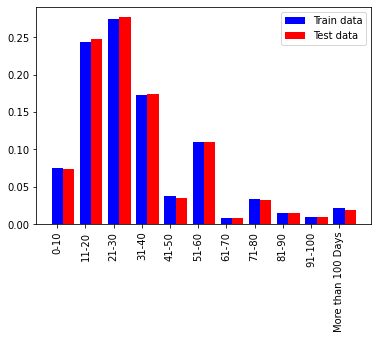

In [23]:
# Dataor plotting 
y1 = y_train_unique, y_train_counts / len(y_train)
y2 = y_test_unique, y_test_counts / len(y_test)
labels = {
            1 : "0-10",
            2 : "11-20",
            3 : "21-30",
            4 : "31-40",
            5 : "41-50",
            6 : "51-60",
            7 : "61-70",
            8 : "71-80",
            9 : "81-90",
            10 : "91-100",
            11 : "More than 100 Days"
        }

barWidth = .4

x_axis = np.arange(len(y1[0]))

# Actual plot
fig, ax = plt.subplots()

ax.bar(x_axis, y1[1], color = "b", width = barWidth, label = "Train data")
ax.bar(x_axis + barWidth, y2[1], color = "r", width = barWidth, label = "Test data")

# Extras
plt.xticks(x_axis, list(labels.values()), rotation = 90)
plt.legend()

plt.show()

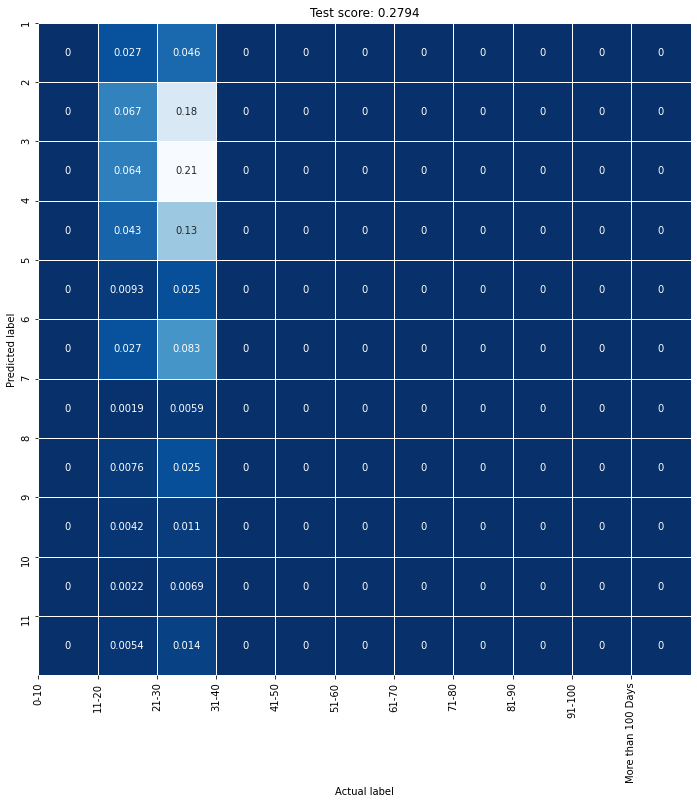

In [48]:
plt.figure(figsize = (12, 12))

sns.heatmap(cm / len(y_test), annot = True, linewidths = .5, square = True, cmap = "Blues_r", cbar = False)

plt.xticks(range(0, 11), list(labels.values()), rotation = 90)
plt.yticks(range(0, 11), range(1, 12))

plt.xlabel("Actual label")
plt.ylabel("Predicted label")

plt.title(f"Test score: {test_score_}")

plt.show()

We can see that the model is doing the best work at predicting the 3rd label but for the rest, even the other label that is predicting (2nd one) is doing poorly.